In [14]:
import pandas as pd
import numpy as np
import math
import time
import copy
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import collections
import community as community_louvain
import seaborn

import helper.visualization as viz
from helper.cluster import *

#%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

In [18]:
sns.color_palette("husl", 12)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)]

### Parameters

In [66]:
number_of_groups = 7

random_states = {
  "heuristic6": 39,
  "heuristic7": 24,
  "agreement6": 10,
  "agreement7": 21,
  "cohen6": 25,
  "cohen7": 16,
  "krippendorff6": 6,
  "krippendorff7": 41
}


path_comments = "00_data/attack_annotated_comments.tsv"
path_annotations = "00_data/attack_annotations.tsv"
path_workers = "00_data/attack_worker_demographics.tsv"

path_graph = "./01_processed_data/200903_run_004/200903_00_graph_"
path_store = "./01_processed_data/200903_run_004/datasplits/200903_louvian"
path_images = "./03_results/200903_run_004/"

types = ['agreement','cohen','krippendorff','heuristic']
selected_type  = types[2]
random_state = random_states[selected_type+str(number_of_groups)]

In [3]:
path_store = path_store + "_" + selected_type

In [4]:
G = nx.read_gexf(path_graph + selected_type + ".gexf")

In [5]:
pos = nx.spring_layout(G, k=0.1)


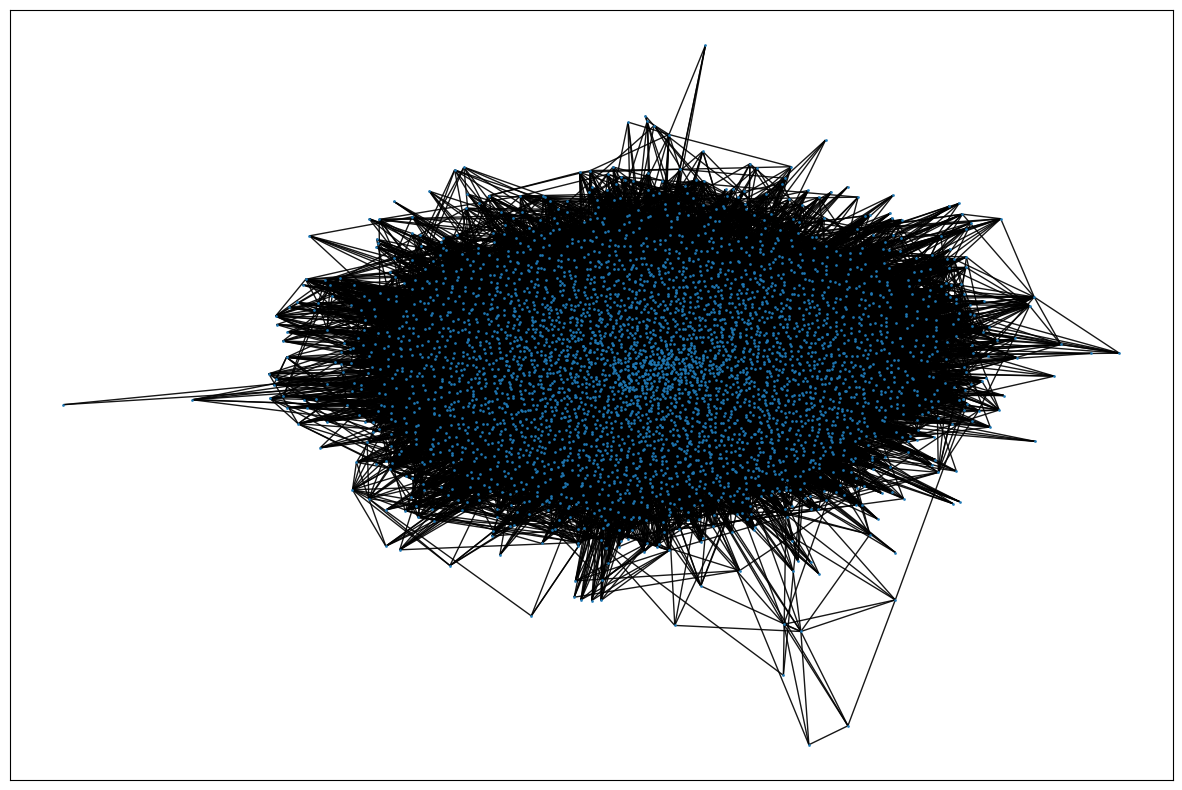

In [6]:
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=1, 
    #edgelist=[],
    edge_color="#000000", 
    alpha=0.91, 
    with_labels=False)
plt.show()

### Load data

### Community detection

In [7]:
group_list = getCommunityGroups(G,method="louvian",random_state=random_state)
len(group_list)

12

In [8]:
cn = 0
for c in group_list:
    cn = cn + 1
    for v in c:
        # Add 1 to save 0 for external edges
        G.nodes[v]['community'] = cn

In [27]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b) 
    return sns.color_palette("hls", 12)[i]



def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

In [28]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]


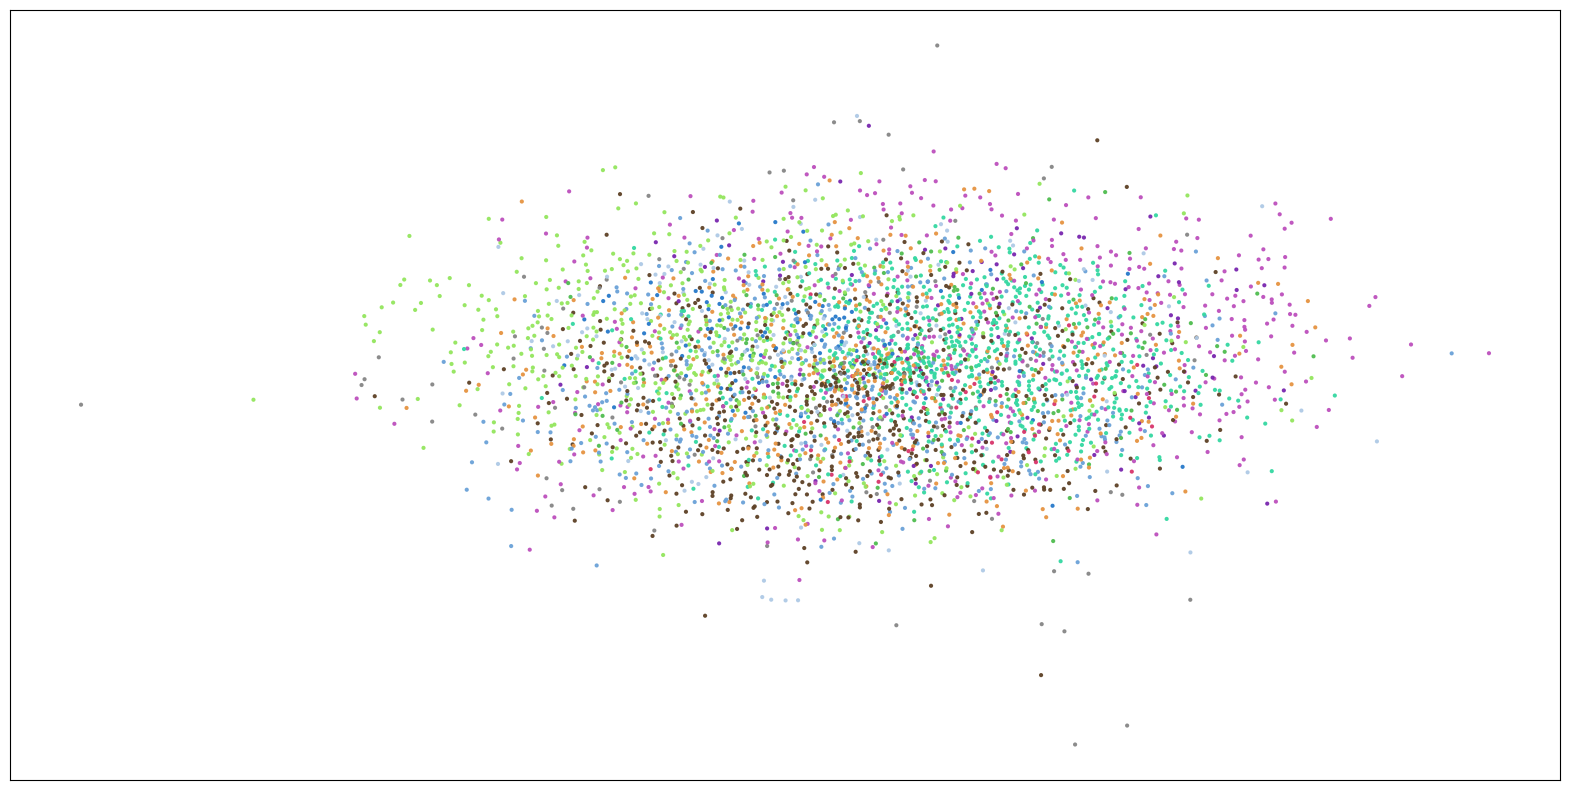

In [29]:
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_color,
    node_size=4,
    edgelist=[],
    edge_color="#444444", 
    alpha=0.91, 
    with_labels=False)
plt.show()

In [76]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (20, 10)})
plt.style.use('seaborn-dark')

# Set node and edge communities
#set_node_community(G_social, communities)
set_edge_community(G)

# Set community color for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ["#808080" for e in internal]
node_color = [get_color(G.nodes[v]['community'],r_off=1, g_off=3, b_off=2) for v in G.nodes]
# external edges
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=0, 
    edgelist=external, 
    #edge_color="#ffffff",
    edge_color="#808080",
    node_color=node_color,
    alpha=0.01, 
    with_labels=False)
# internal edges
nx.draw_networkx(
    G,
    pos=pos, 
    node_size=0,
    edgelist=internal, 
    #edgelist=[],
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.01, 
    with_labels=False)
nx.draw_networkx(
    G,
    pos=pos, 
    node_size=3,
    #edgelist=internal, 
    edgelist=[],
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.9, 
    with_labels=False)
#plt.show()
plt.savefig(path_images+ "200309-graph-" + selected_type + "-"+ str(number_of_groups)+ "-groups.png",dpi=300)

### Remove small communities

In [ ]:
group_list = removeSmallGroup(group_list,min_size_group)

group_list.insert(0,[])
for i in range(0,len(group_list)):
    print("Group", i,"and size of",len(group_list[i]))

## Create data sets for each community (leave-out and single only)

In [ ]:
group_dfs_each,group_dfs_leave_out = getGroupSpecificDataSlices(group_list,df_annotations,df_comments)
print("Length group_dfs_each:",len(group_dfs_each))
print("Length group_dfs_leave_out:",len(group_dfs_leave_out))

## Identify shared comments

In [ ]:
shared_comments = getSharedComments(group_dfs_each)
print("Number of shared comments between all groups:\t\t\t",len(shared_comments))

shared_comments_leave_out = getSharedComments(group_dfs_leave_out)
print("Number of shared comments leave out between all groups:\t\t",len(shared_comments_leave_out))

not_contained_comments= getNotContainedComments(group_dfs_each,df_comments)
print("Number of comments that are not contained in all groups:\t",len(not_contained_comments))

In [ ]:
shared_comments

In [ ]:
# data set sizes of 
for group in group_dfs_each:
    print(len(group))

In [ ]:
group_dfs_each[0].head()

## Create training and test sets

In [89]:
import sklearn.metrics as me

v1 = [1,0,0]
v2 = [0,1,1]

me.cohen_kappa_score(v1,v2)

-0.8000000000000003

In [98]:
v1 = [1]
v2 = [1]

me.cohen_kappa_score(v1,v2)

nan

In [99]:
if np.NaN < 0:
    print("True")
else:
    print("False")

False
